# Introduction

This notebook is a clustring analysis for a retail shop data. The clustring is based on Recency, Frequency and Monetary value.

In [28]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import datetime
import math

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
 

In [29]:
import pandas as pd
Customer_df=pd.read_csv('Online_Retail_clean.csv',dtype={'CustomerID': str,'InvoiceID': str})
Customer_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


In [3]:
Customer_df.describe()

,InvoiceNo,Quantity,UnitPrice
count,397884.000000,397884.000000,397884.000000
mean,560616.934451,12.988238,3.116488
std,13106.117773,179.331775,22.097877
min,536365.000000,1.000000,0.001000
25%,549234.000000,2.000000,1.250000
50%,561893.000000,6.000000,1.950000
75%,572090.000000,12.000000,3.750000
max,581587.000000,80995.000000,8142.750000


In [4]:
#removing negative values and replacing them with zero
Customer_df.loc[Customer_df['Quantity']<0,'Quantity']=0
Customer_df.loc[Customer_df['UnitPrice']<0,'UnitPrice']=0

In [5]:
#looking for null values
Customer_df[Customer_df.isnull().any(axis=1)]


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


In [6]:
# drop rows with null values if they exist 
#Customer_df=Customer_df.dropna(how='any',axis=0)
 

In [7]:
Customer_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397884 entries, 0 to 397883
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    397884 non-null  int64  
 1   StockCode    397884 non-null  object 
 2   Description  397884 non-null  object 
 3   Quantity     397884 non-null  int64  
 4   InvoiceDate  397884 non-null  object 
 5   UnitPrice    397884 non-null  float64
 6   CustomerID   397884 non-null  object 
 7   Country      397884 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 24.3+ MB


In [8]:
Customer_df.InvoiceDate = pd.to_datetime(Customer_df.InvoiceDate)
#calculate the amount spent in each transaction
Customer_df['amount'] = Customer_df.Quantity*Customer_df.UnitPrice
# reference date is one day after transaction day so that the minimum recency is 1
refrence_date = Customer_df.InvoiceDate.max() + datetime.timedelta(days = 1)


In [9]:
# recency is the number of days since the reference date
Customer_df['recency'] = (refrence_date - Customer_df.InvoiceDate).astype('timedelta64[D]')
# group recency by customer, finding the most recent purchase by the customer
Customer_Recency_df = Customer_df[['CustomerID', 'recency']].groupby("CustomerID").min().reset_index()
Customer_Recency_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
recency,4338.0,92.536422,100.014169,1.0,18.0,51.0,142.0,374.0


In [10]:
#number of purchases per customer. group by invoice number because there might be multiple rows per customer per invoice.
Customer_freq = (Customer_df[['CustomerID', 'InvoiceNo']].groupby(["CustomerID", 'InvoiceNo']).count().reset_index()).\
                groupby(["CustomerID"]).count().reset_index()
Customer_freq.rename(columns={'InvoiceNo':'frequency'},inplace=True)


In [11]:
# amount: monetary value the amount spend by each customer
Customer_monetary_val = Customer_df[['CustomerID', 'amount']].groupby("CustomerID").sum().reset_index()
Customer_RFM =Customer_Recency_df.merge(Customer_freq).merge(Customer_monetary_val)
Customer_RFM.loc[Customer_RFM['amount']==0,'amount']=0.0001
Customer_RFM.describe()

,recency,frequency,amount
count,4338.000000,4338.000000,4338.000000
mean,92.536422,4.272015,2054.266460
std,100.014169,7.697998,8989.230441
min,1.000000,1.000000,3.750000
25%,18.000000,1.000000,307.415000
50%,51.000000,2.000000,674.485000
75%,142.000000,5.000000,1661.740000
max,374.000000,209.000000,280206.020000


The Data is skewed so log transform and standard scaler helps to normalize it.

In [12]:
 
Customer_RFM['recency_log'] = Customer_RFM['recency'].apply(math.log)
Customer_RFM['frequency_log'] =Customer_RFM['frequency'].apply(math.log)
Customer_RFM['amount_log'] =Customer_RFM['amount'].apply(math.log)
scaler = StandardScaler()
scaled_features = scaler.fit_transform(Customer_RFM[['amount_log', 'recency_log','frequency_log']])


# Number of clusters
To determin the optimal number of clusters silhouette analysis is used.

In [25]:
# this is to toggle scrolling off for the graphs
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

UsageError: Line magic function `%%javascript` not found.


For n_clusters = 2 The average silhouette_score is : 0.43200903295690735
For n_clusters = 3 The average silhouette_score is : 0.33901383843800725
For n_clusters = 4 The average silhouette_score is : 0.3345277352853132
For n_clusters = 5 The average silhouette_score is : 0.3038631742952295
For n_clusters = 6 The average silhouette_score is : 0.31007633751053487


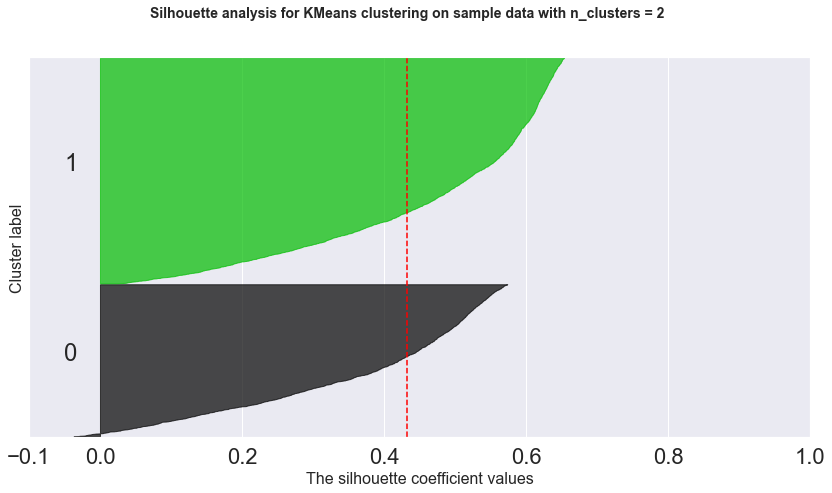

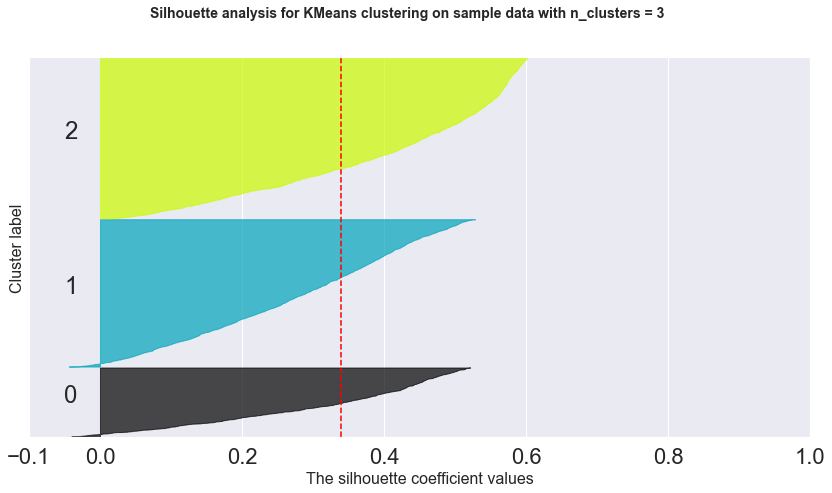

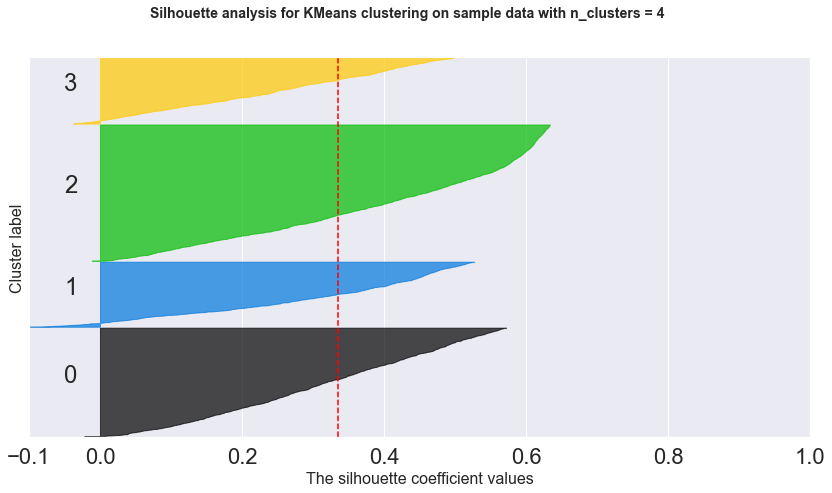

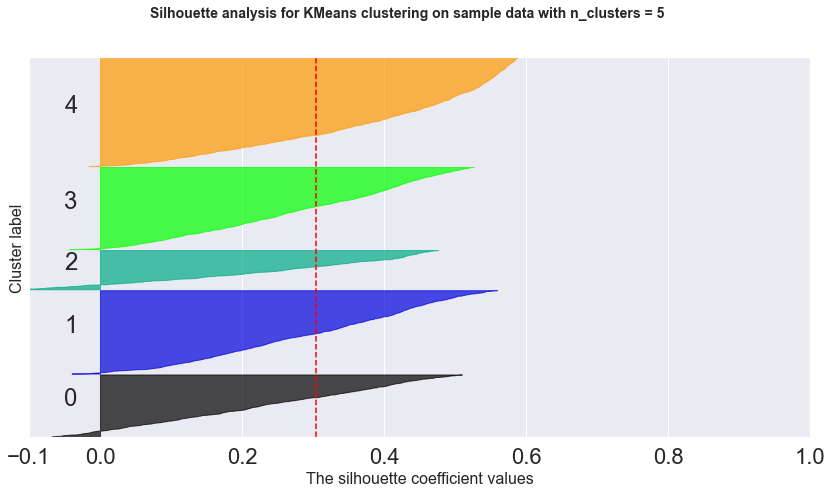

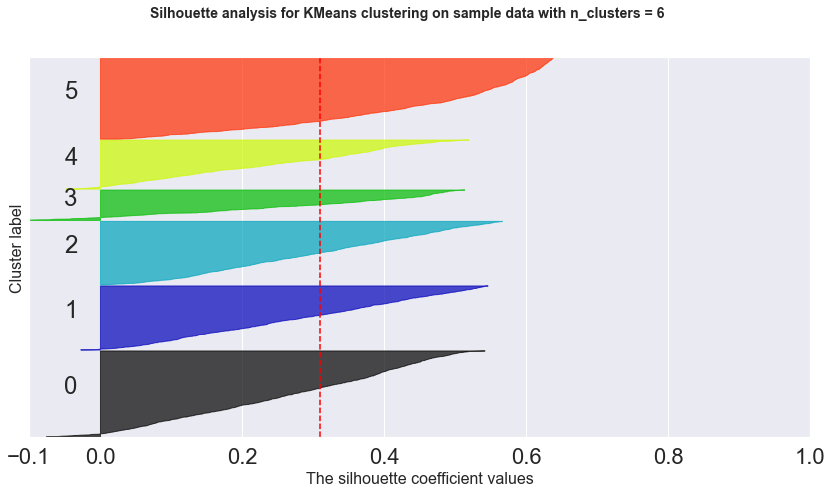

In [27]:

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(14, 7)

    
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(scaled_features) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, init="random", n_init=10, max_iter=300,random_state=42)
    cluster_labels = clusterer.fit_predict(scaled_features)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(scaled_features, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(scaled_features, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    #ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values",size=16)
    ax1.set_ylabel("Cluster label",size=16)

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

   

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )



The silhouette analysis shows that 4 clusters are good for this model. However, the number of clusters should be determined based on the Silhouette analysis, this will be added at the end of the analysis later.

In [20]:

kmeans = KMeans(n_clusters=4, init="random", n_init=10, max_iter=300,random_state=42)
kmeans.fit(scaled_features)

# join the clusters to the main data
Customer_RFM['clusters_4'] = kmeans.labels_
cluster_centers=kmeans.cluster_centers_

In [21]:
display(Customer_RFM.head())
features = ['amount',  'recency',  'frequency']
scaler.inverse_transform(kmeans.cluster_centers_)
data_inversed = scaler.inverse_transform(cluster_centers)
data_transformed=pd.DataFrame(np.exp(data_inversed),columns=features)
data_transformed.reset_index(inplace=True)
data_transformed.rename(columns={"index": "Cluster"},inplace=True)

,CustomerID,recency,frequency,amount,recency_log,frequency_log,amount_log,clusters_4
0,12346.0,326.0,1,77183.60,5.786897,0.000000,11.253942,0
1,12347.0,2.0,7,4310.00,0.693147,1.945910,8.368693,1
2,12348.0,75.0,4,1797.24,4.317488,1.386294,7.494007,0
3,12349.0,19.0,1,1757.55,2.944439,0.000000,7.471676,3
4,12350.0,310.0,1,334.40,5.736572,0.000000,5.812338,2


(0.0, 75.0)

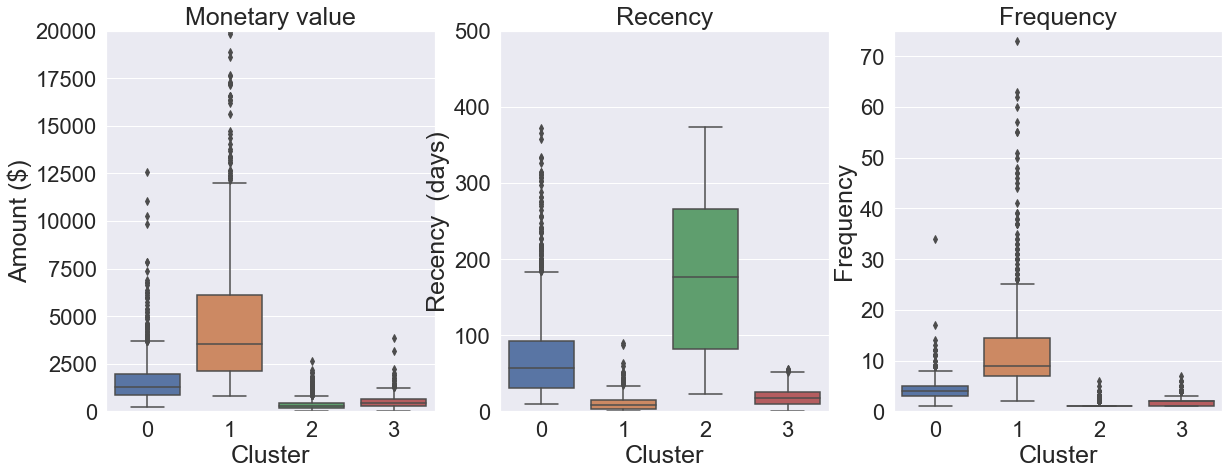

In [22]:
# visualizing the clusters
sns.set_style("darkgrid")
fig = plt.figure(figsize=(20,7))
f1 = fig.add_subplot(131)
sns.set(font_scale =2)
ax1=sns.boxplot(x=Customer_RFM['clusters_4'],y=Customer_RFM['amount'])
ax1.set_title('Monetary value', fontsize = 25)
ax1.set_ylabel('Amount ($)', fontsize =25)
ax1.set_xlabel ('Cluster', fontsize = 25)
ax1.set_ylim(top=20000,bottom=0)

f1 = fig.add_subplot(132)
sns.set(font_scale = 2)
ax2=sns.boxplot(x=Customer_RFM['clusters_4'],y=Customer_RFM[ 'recency'])
ax2.set_title('Recency', fontsize =25)
ax2.set_ylabel('Recency  (days)', fontsize =25)
ax2.set_xlabel ('Cluster', fontsize = 25)
ax2.set_ylim(top=500,bottom=0)

f1 = fig.add_subplot(133)
sns.set(font_scale = 2)
ax3=sns.boxplot(x=Customer_RFM['clusters_4'],y=Customer_RFM[ 'frequency'])
ax3.set_title('Frequency', fontsize = 25)
ax3.set_ylabel('Frequency', fontsize =25)
ax3.set_xlabel ('Cluster', fontsize = 25)
ax3.set_ylim(top=75,bottom=0)


### Discussion 
Customers in cluster 0 are hibernating. Their last purchase was was a long time ago, the are low spenders with little number of orders. The proposed action for this group is to recreate brand value by offering other relevant products and special discounts.

Cluster 1 are promising customers. They bought recently but didn’t spend much. A good action is to create brand awareness and offer deals.

Cluster 2 are the champions. This group buy often, buy recently and spend the most. This group should be rewarded. They can be early adopters of the new products, and they can promote the brand. This group would be a good target for cross-sell/upsell.

Cluster 3 made big purchases, and often, but not recently! Win them back via newer products, don’t lose them to competition. 
